In [46]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.8.0
sys.version_info(major=3, minor=7, micro=13, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.8.0
keras.api._v2.keras 2.8.0


In [47]:
!nvidia-smi

Wed Jun  1 05:34:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    34W /  70W |   1452MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [48]:
# 1. loads data
# 2. preprocesses data -> dataset
# 3. tools
# 3.1 generates position embedding 位置编码
# 3.2 create mask. (a. padding, b. decoder)
# 3.3 scaled_dot_product_attention 缩放点积注意力
# 4. builds model 分为以下6步
    # 4.1 MultiheadAttention 多头注意力
    # 4.2 EncoderLayer
    # 4.3 DecoderLayer
    # 4.4 EncoderModel
    # 4.5 DecoderModel
    # 4.6 Transformer
# 5. optimizer & loss
# 6. train step -> train
# 7. Evaluate and Visualize

# 1 loads data

In [49]:
import tensorflow_datasets as tfds
# 葡萄牙语->英语，这个是基于subword的
# as_supervised是True是tuple，是False返回的是字典
examples, info = tfds.load('ted_hrlr_translate/pt_to_en',
                           with_info = True,
                           as_supervised = True)
print(type(examples))  # examples是字典，里边有训练集，验证集，测试集
train_examples, val_examples = examples['train'], examples['validation']
print(info)  # info里是数据集的描述

<class 'dict'>
tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    version=1.0.0,
    description='Data sets derived from TED talk transcripts for comparing similar language pairs
where one is high resource and the other is low resource.',
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=54781,
    splits={
        'test': 1803,
        'train': 51785,
        'validation': 1193,
    },
    supervised_keys=('pt', 'en'),
    citation="""@inproceedings{Ye2018WordEmbeddings,
      author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig},
      title   = {When and Why are pre-trained word embeddings useful for Neural Machine Translation},
      booktitle = {HLT-NAACL},
      year    = {2018},
      }""",
    redistribution_info=,
)



In [50]:
# 葡萄牙语中有一些特除的字符，用转义字符来打印
for pt, en in train_examples.take(5):
    print(pt.numpy())
    print(en.numpy())
    print(type(pt))
print(train_examples)

b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'
b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'
<class 'tensorflow.python.framework.ops.EagerTensor'>
b'mas e se estes fatores fossem ativos ?'
b'but what if it were active ?'
<class 'tensorflow.python.framework.ops.EagerTensor'>
b'mas eles n\xc3\xa3o tinham a curiosidade de me testar .'
b"but they did n't test for curiosity ."
<class 'tensorflow.python.framework.ops.EagerTensor'>
b'e esta rebeldia consciente \xc3\xa9 a raz\xc3\xa3o pela qual eu , como agn\xc3\xb3stica , posso ainda ter f\xc3\xa9 .'
b'and this conscious defiance is why i , as an agnostic , can still have faith .'
<class 'tensorflow.python.framework.ops.EagerTensor'>
b"`` `` '' podem usar tudo sobre a mesa no meu corpo . ''"
b'you can use everything on the table on me .'
<class 'tensorflow.python.framework.ops.EagerTensor'>
<PrefetchDat

In [51]:
2**13

8192

# 2 preprocesses data

In [52]:
# time-consuming
# 转为subword数据集，2**13=8192，build_from_corpus
en_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples),
    target_vocab_size = 2 ** 13)
pt_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples),
    target_vocab_size = 2 ** 13)


In [53]:
# 测试一个字符串,subword里面是包含空格的
sample_string = "Transformer is awesome."

tokenized_string = en_tokenizer.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

origin_string = en_tokenizer.decode(tokenized_string)
print('The original string is {}'.format(origin_string))

assert origin_string == sample_string

for token in tokenized_string:
    print('{} --> "{}"-->{}'.format(token, en_tokenizer.decode([token]),len(en_tokenizer.decode([token]))))

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string is Transformer is awesome.
7915 --> "T"-->1
1248 --> "ran"-->3
7946 --> "s"-->1
7194 --> "former "-->7
13 --> "is "-->3
2799 --> "awesome"-->7
7877 --> "."-->1


In [54]:
# 真正拆出来的词根是接近8192，刚好等于的概率很小
pt_tokenizer.vocab_size

8214

In [55]:
en_tokenizer.vocab_size

8087

In [56]:
origin_string = en_tokenizer.decode([8086])
print(len(origin_string))
print('The original string is {}'.format(origin_string))

1
The original string is �


In [57]:
buffer_size = 20000
batch_size = 64
max_length = 40  # 输入和输出的最大长度是40

# 把两段文本转为subword的id形式，
def encode_to_subword(pt_sentence, en_sentence):
    pt_sequence = [pt_tokenizer.vocab_size] \
    + pt_tokenizer.encode(pt_sentence.numpy()) \
    + [pt_tokenizer.vocab_size + 1]
    en_sequence = [en_tokenizer.vocab_size] \
    + en_tokenizer.encode(en_sentence.numpy()) \
    + [en_tokenizer.vocab_size + 1]
    return pt_sequence, en_sequence

# 用tf的API消去大于最大长度的
def filter_by_max_length(pt, en):
    return tf.logical_and(tf.size(pt) <= max_length,
                          tf.size(en) <= max_length)
# 用py_function封装一下encode_to_subword
def tf_encode_to_subword(pt_sentence, en_sentence):
    return tf.py_function(encode_to_subword,
                          [pt_sentence, en_sentence],
                          [tf.int64, tf.int64])
# 把所有句子变为subword，subword都变为id
train_dataset = train_examples.map(tf_encode_to_subword)
train_dataset = train_dataset.filter(filter_by_max_length)  # 去掉长度超过40的（subword的40）
# next: 洗牌，padding，batch    [-1]，[-1]代表两个维度，每个维度都在当前维度下扩展到最高的值？
train_dataset = train_dataset.shuffle(
    buffer_size).padded_batch(
    batch_size, padded_shapes=([-1], [-1]))  # 葡萄牙语，英语都补到40，有两个[-1],不够补0

valid_dataset = val_examples.map(tf_encode_to_subword)
valid_dataset = valid_dataset.filter(
    filter_by_max_length).padded_batch(
    batch_size, padded_shapes=([-1], [-1]))
    

In [58]:
# 不同batch不一致，是因为先batch，后padding的
for pt_batch, en_batch in train_dataset.take(5):
    print(pt_batch.shape, en_batch.shape)

(64, 39) (64, 38)
(64, 39) (64, 39)
(64, 40) (64, 38)
(64, 36) (64, 37)
(64, 37) (64, 37)


In [59]:
np.arange(13)[:, np.newaxis]

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12]])

In [60]:
np.arange(256)[np.newaxis, :]

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

# 3 tools

# 3.1 generates position embedding

In [61]:
# 第三步，写一些工具函数
# PE(pos, 2i)   = sin(pos/10000^(2i/d_model))
# PE(pos, 2i+1) = cos(pos/10000^(2i/d_model))

# pos和i都是矩阵
# pos.shape: [sentence_length, 1]
# i.shape  : [1, d_model]
# result.shape: [sentence_length, d_model]
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000,
                               (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

# 计算位置信息
def get_position_embedding(sentence_length, d_model):
    # sentence_length和d_model都扩展为矩阵
#     print(np.arange(sentence_length)[:, np.newaxis])
#     print(np.arange(d_model)[np.newaxis, :])
    # pos是0到49，就是词的位置，i是从0到511，总计512，和dim相等
    angle_rads = get_angles(np.arange(sentence_length)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    print('angle_rads.shape:',end='')
    print(angle_rads.shape)
    # sines.shape: [sentence_length, d_model / 2]
    # cosines.shape: [sentence_length, d_model / 2]
    # 正弦一半，余弦一半
    print(angle_rads[:, 0::2].shape)
    print(angle_rads[:, 1::2].shape)
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])
    
    # 把sines和cosines进行拼接
    # position_embedding.shape: [sentence_length, d_model]
    position_embedding = np.concatenate([sines, cosines], axis = -1)
    # 进行维度扩展
    # position_embedding.shape: [1, sentence_length, d_model]
    position_embedding = position_embedding[np.newaxis, ...]
    # 变为float32类型
    return tf.cast(position_embedding, dtype=tf.float32)

position_embedding = get_position_embedding(50, 512)
print(position_embedding)

angle_rads.shape:(50, 512)
(50, 256)
(50, 256)
tf.Tensor(
[[[ 0.          0.          0.         ...  1.          1.
    1.        ]
  [ 0.84147096  0.8218562   0.8019618  ...  1.          1.
    1.        ]
  [ 0.9092974   0.9364147   0.95814437 ...  1.          1.
    1.        ]
  ...
  [ 0.12357312  0.97718984 -0.24295525 ...  0.9999863   0.99998724
    0.99998814]
  [-0.76825464  0.7312359   0.63279754 ...  0.9999857   0.9999867
    0.9999876 ]
  [-0.95375264 -0.14402692  0.99899054 ...  0.9999851   0.9999861
    0.9999871 ]]], shape=(1, 50, 512), dtype=float32)


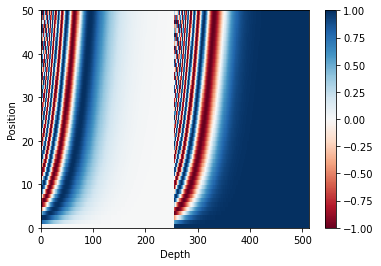

In [62]:
# 绘制位置编码示意图
def plot_position_embedding(position_embedding):
    plt.pcolormesh(position_embedding[0], cmap = 'RdBu')
    plt.xlabel('Depth')
    plt.xlim((0, 512))
    plt.ylabel('Position')
    plt.colorbar()
    plt.show()
    
plot_position_embedding(position_embedding)

# 3.2 create mask(padding & decoder)

In [63]:
# 如何生成mask
# 1. padding mask 2. look ahead

# batch_data.shape: [batch_size, seq_len]
def create_padding_mask(batch_data):
    padding_mask = tf.cast(tf.math.equal(batch_data, 0), tf.float32)
    # [batch_size, 1, 1, seq_len]
    return padding_mask[:, tf.newaxis, tf.newaxis, :]
# 设置3x5矩阵，0都是padding，是零的得到的都是1，非零的位置都是零
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [64]:
# attention_weights.shape: [3,3]
# 第一个位置代表第一个单词和自己的attention，第二位置是第二个单词和第一个单词的attention
# 看不到后面的词刚好是下三角，使用库函数来实现
# [[1, 0, 0],
#  [4, 5, 0],
#  [7, 8, 9]]
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

# 前面看不到后面的padding，矩阵下面全部为0
# 在mask里，应该被忽略的我们会设成1，应该被保留的会设成0，
# 而如果mask相应位置上为1，那么我们就给对应的logits 
# 加上一个超级小的负数， (mask * -1e9)， 这样，
# 对应的logits也就变成了一个超级小的数。然后在计算softmax的时候，
# 一个超级小的数的指数会无限接近与0，也就是它对应的attention的权重就是0了
create_look_ahead_mask(3)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

# 3.3 scaled_dot_product_attention 缩放点积注意力

In [65]:
# 参考文档，q是query，k，v代表key和value，q和k做完矩阵乘法后，做mask
def scaled_dot_product_attention(q, k, v, mask):
    """
    Args:
    - q: shape == (..., seq_len_q, depth)
    - k: shape == (..., seq_len_k, depth)
    - v: shape == (..., seq_len_v, depth_v)
    - seq_len_k == seq_len_v  这两个是相等的
    - mask: shape == (..., seq_len_q, seq_len_k)
    Returns:
    - output: weighted sum
    - attention_weights: weights of attention
    """
    # 计算attentions时，只用了后两维在计算
    # transpose_b代表第二个矩阵（即k）是否做转置，且为True时仅是把k的最后两维交换位置
    # matmul_qk.shape: (..., seq_len_q, seq_len_k)
    matmul_qk = tf.matmul(q, k, transpose_b = True)
    
    # 获得dk，cast转换类型
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    # 然后根据文档中的公式除以dk
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # 这一步是mask应用的核心啊
    # 如果mask不是空的话，给scaled_attention_logits加一个mask（缩放）
    if mask is not None:
        # 使得在softmax后值趋近于0
        scaled_attention_logits += (mask * -1e9)
    
    # attention_weights.shape: (..., seq_len_q, seq_len_k)
    attention_weights = tf.nn.softmax(
        scaled_attention_logits, axis = -1)
    
    # 根据原理图，v和attention_weights进行矩阵乘法
    # output.shape: (..., seq_len_q, depth_v)
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

# 调用上面的函数，去验证
def print_scaled_dot_product_attention(q, k, v):
    temp_out, temp_att = scaled_dot_product_attention(q, k, v, None)
    print("Attention weights are:")
    print(temp_att)
    print("Output is:")
    print(temp_out)
    

In [66]:
# 定义一个测试的Q，K，V
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32) # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32) # (4, 2)

temp_q1 = tf.constant([[0, 10, 0]], dtype=tf.float32) # (1, 3)
# 做四舍五入，让结果清爽
np.set_printoptions(suppress=True)

print_scaled_dot_product_attention(temp_q1, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [67]:
temp_q2 = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
# 0.  0.  0.5 0.5 会和temp_v去做平均，因此得到的是550,5.5
print_scaled_dot_product_attention(temp_q2, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [68]:
temp_q3 = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_scaled_dot_product_attention(temp_q3, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [69]:
# 拼起来再来测试
temp_q4 = tf.constant([[0, 10, 0],
                       [0, 0, 10],
                       [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_scaled_dot_product_attention(temp_q4, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  1.  0.  0. ]
 [0.  0.  0.5 0.5]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[ 10.    0. ]
 [550.    5.5]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


# 4 builds model

# 4.1 multihead attention 多头注意力

In [70]:
q=np.ones((1,8,60,64))
k=np.ones((1,8,60,64))
v=np.ones((1,8,60,64))
d=tf.matmul(q, k, transpose_b = True)
print(d.shape)
tf.matmul(d,v).shape

(1, 8, 60, 60)


TensorShape([1, 8, 60, 64])

In [71]:
# 多头注意力的实现->多个缩放点积注意力
class MultiHeadAttention(keras.layers.Layer):
    """
    理论上:
    x -> Wq0 -> q0
    x -> Wk0 -> k0
    x -> Wv0 -> v0
    
    实战中:把三个概念区分开
    q -> Wq0 -> q0
    k -> Wk0 -> k0
    v -> Wv0 -> v0
    
    实战中技巧：q乘以W得到一个大的Q，然后分割为多个小q
    q -> Wq -> Q -> split -> q0, q1, q2...
    """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert self.d_model % self.num_heads == 0
        
        # 大Q变小q怎么变，层次
        self.depth = self.d_model // self.num_heads
        
        self.WQ = keras.layers.Dense(self.d_model)
        self.WK = keras.layers.Dense(self.d_model)
        self.WV = keras.layers.Dense(self.d_model)
        # 拼接
        self.dense = keras.layers.Dense(self.d_model)
    
    def split_heads(self, x, batch_size):
        # x.shape: (batch_size, seq_len, d_model)
        # d_model = num_heads * depth
        # 把x变为下面维度，用reshape
        # x -> (batch_size, num_heads, seq_len, depth)
        
        x = tf.reshape(x,
                       (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])  # 轴滚动
    
    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0]
        # 经过Q K V变化
        # print(q.shape)
        q = self.WQ(q)  # q.shape: (batch_size, seq_len_q, d_model)
        k = self.WK(k)  # k.shape: (batch_size, seq_len_k, d_model)
        v = self.WV(v)  # v.shape: (batch_size, seq_len_v, d_model)
        # print('-'*50)
        # print(q.shape)
        # q.shape: (batch_size, num_heads, seq_len_q, depth)
        q = self.split_heads(q, batch_size)
        # print('分割后的q:',end='')
        # print(q.shape)
        # k.shape: (batch_size, num_heads, seq_len_k, depth)
        k = self.split_heads(k, batch_size)
        # v.shape: (batch_size, num_heads, seq_len_v, depth)
        v = self.split_heads(v, batch_size)
        
        # 开始做缩放点积，得到的多头的信息存在在num_heads，depth上
        # scaled_attention_outputs.shape: (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape: (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention_outputs, attention_weights = \
        scaled_dot_product_attention(q, k, v, mask)
        # print('-'*50)
        # print('scaled_attention_outputs.shape:',end='')
        # print(scaled_attention_outputs.shape)
        # print('attention_weights.shape:',end='')
        # print(attention_weights.shape)
        # print('-'*50)
        # 因此这里做一下转置，让num_heads，depth在后面
        # scaled_attention_outputs.shape: (batch_size, seq_len_q, num_heads, depth)
        scaled_attention_outputs = tf.transpose(
            scaled_attention_outputs, perm = [0, 2, 1, 3])
        # print('attention_weights.shape:',end='')
        # print(scaled_attention_outputs.shape)
        # 对注意力进行合并
        # concat_attention.shape: (batch_size, seq_len_q, d_model)
        concat_attention = tf.reshape(scaled_attention_outputs,
                                      (batch_size, -1, self.d_model))
        
        # 多头注意力计算完毕
        # output.shape : (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)
        
        return output, attention_weights
    
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
# 创建一份虚拟数据
y = tf.random.uniform((1, 60, 256))  # (batch_size, seq_len_q, dim)
# 开始计算，把y既当q，又当k，v
output, attn = temp_mha(y, y, y, mask = None)
print(output.shape)
print(attn.shape)

(1, 60, 512)
(1, 8, 60, 60)


In [72]:
# 定义feed_forward_network，d_model: 节点数
def feed_forward_network(d_model, dff):
    # dff: dim of feed forward network.
    return keras.Sequential([
        keras.layers.Dense(dff, activation='relu'),
        keras.layers.Dense(d_model)
    ])

sample_ffn = feed_forward_network(512, 2048)
# 给一个输入测试
sample_ffn(tf.random.uniform((64, 40, 512))).shape

TensorShape([64, 40, 512])

# 4.2 EncoderLayer

In [73]:
# 自定义EncoderLayer
class EncoderLayer(keras.layers.Layer):
    """
    x -> self attention -> add & normalize & dropout
      -> feed_forward -> add & normalize & dropout
    原理对应文档Add & Normalize 标题下的图
    """
    # d_model给self attention和feed_forward_network，num_heads给self_attention用的
    # dff给feed_forward_network，rate是做dropout的
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = feed_forward_network(d_model, dff)
        
        # epsilon 将小浮点数添加到方差以避免被零除
        self.layer_norm1 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        # 下面两个层次用了做dropout，每次有10%的几率被drop掉
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
    
    def call(self, x, training, encoder_padding_mask):
        # x.shape          : (batch_size, seq_len, dim=d_model)
        # attn_output.shape: (batch_size, seq_len, d_model)
        # out1.shape       : (batch_size, seq_len, d_model)
        # x作为q，k，v  原理对应文档Add & Normalize 标题下的图
        attn_output, _ = self.mha(x, x, x, encoder_padding_mask)
        attn_output = self.dropout1(attn_output, training=training)
        # dim=d_model 两个必须相等，这样x才可以和attn_output做加法
        out1 = self.layer_norm1(x + attn_output)
        
        # ffn_output.shape: (batch_size, seq_len, d_model)
        # out2.shape      : (batch_size, seq_len, d_model)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layer_norm2(out1 + ffn_output)
        
        return out2
# 测试，结果与最初的输入维度一致，相当于做了两次残差连接
sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_input = tf.random.uniform((64, 40, 512))
sample_output = sample_encoder_layer(sample_input, False, None)
print(sample_output.shape)

(64, 40, 512)


In [74]:
sample_encoder_layer.variables

[<tf.Variable 'encoder_layer_9/multi_head_attention_29/dense_158/kernel:0' shape=(512, 512) dtype=float32, numpy=
 array([[-0.07269425, -0.02172845,  0.03022368, ..., -0.0445837 ,
          0.06158007,  0.01299228],
        [-0.00279603,  0.03706963, -0.07378405, ..., -0.03569598,
          0.00161891, -0.07084925],
        [-0.0667477 ,  0.07194062,  0.07426592, ...,  0.00488634,
          0.05725632, -0.06169483],
        ...,
        [-0.05803926,  0.00137741,  0.01308957, ..., -0.05543611,
          0.07180598, -0.06267793],
        [ 0.0001921 , -0.0366058 ,  0.05820429, ...,  0.07595343,
          0.03771806, -0.0144515 ],
        [-0.06846354, -0.02164631, -0.05761899, ...,  0.02729866,
         -0.01320945,  0.07294603]], dtype=float32)>,
 <tf.Variable 'encoder_layer_9/multi_head_attention_29/dense_158/bias:0' shape=(512,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [75]:
sample_encoder_layer.trainable_variables

[<tf.Variable 'encoder_layer_9/multi_head_attention_29/dense_158/kernel:0' shape=(512, 512) dtype=float32, numpy=
 array([[-0.07269425, -0.02172845,  0.03022368, ..., -0.0445837 ,
          0.06158007,  0.01299228],
        [-0.00279603,  0.03706963, -0.07378405, ..., -0.03569598,
          0.00161891, -0.07084925],
        [-0.0667477 ,  0.07194062,  0.07426592, ...,  0.00488634,
          0.05725632, -0.06169483],
        ...,
        [-0.05803926,  0.00137741,  0.01308957, ..., -0.05543611,
          0.07180598, -0.06267793],
        [ 0.0001921 , -0.0366058 ,  0.05820429, ...,  0.07595343,
          0.03771806, -0.0144515 ],
        [-0.06846354, -0.02164631, -0.05761899, ...,  0.02729866,
         -0.01320945,  0.07294603]], dtype=float32)>,
 <tf.Variable 'encoder_layer_9/multi_head_attention_29/dense_158/bias:0' shape=(512,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

# 4.3 DecoderLayer

In [76]:
class DecoderLayer(keras.layers.Layer):
    """
    x -> self attention -> add & normalize & dropout -> out1
    out1 , encoding_outputs -> attention -> add & normalize & dropout -> out2
    out2 -> ffn -> add & normalize & dropout -> out3
    """
    def __init__(self, d_model, num_heads, dff, rate = 0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = feed_forward_network(d_model, dff)
        # 因为有两个attention，还有一个feed_forward_network，所以有3个
        # LayerNormalization和3个dropout
        self.layer_norm1 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        self.layer_norm3 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
    
    
    def call(self, x, encoding_outputs, training,
             decoder_mask, encoder_decoder_padding_mask):
        # decoder_mask: 由look_ahead_mask和decoder_padding_mask合并而来
        
        # x.shape: (batch_size, target_seq_len, d_model)
        # encoding_outputs.shape: (batch_size, input_seq_len, d_model)
        
        # 按照上面类的注释的步骤依次来编写call实现
        # attn1, out1.shape : (batch_size, target_seq_len, d_model)
        attn1, attn_weights1 = self.mha1(x, x, x, decoder_mask)
        attn1 = self.dropout1(attn1, training = training)
        out1 = self.layer_norm1(attn1 + x)
        
        # attn2, out2.shape : (batch_size, target_seq_len, d_model)
        attn2, attn_weights2 = self.mha2(
            out1, encoding_outputs, encoding_outputs,
            encoder_decoder_padding_mask)
        attn2 = self.dropout2(attn2, training = training)
        out2 = self.layer_norm2(attn2 + out1)
        
        # ffn_output, out3.shape: (batch_size, target_seq_len, d_model)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layer_norm3(ffn_output + out2)
        
        return out3, attn_weights1, attn_weights2

# 测试
sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_decoder_input = tf.random.uniform((64, 60, 512))
sample_decoder_output, sample_decoder_attn_weights1, sample_decoder_attn_weights2 = sample_decoder_layer(
    sample_decoder_input, sample_output, False, None, None)

print(sample_decoder_output.shape)
print(sample_decoder_attn_weights1.shape)  # 最后一维60是和x的维度一致的
print(sample_decoder_attn_weights2.shape)  # 最后一维60是和x的维度相关的
        

(64, 60, 512)
(64, 8, 60, 60)
(64, 8, 60, 40)


# 4.4 EncoderModel

In [77]:
# EncoderLayer堆叠->EncoderModel
class EncoderModel(keras.layers.Layer):
    def __init__(self, num_layers, input_vocab_size, max_length,
                 d_model, num_heads, dff, rate=0.1):
        super(EncoderModel, self).__init__()
        self.d_model = d_model
        # 这是layers数目
        self.num_layers = num_layers
        self.max_length = max_length
        
        # 构建embedding层
        self.embedding = keras.layers.Embedding(input_vocab_size,
                                                self.d_model)
        # position_embedding.shape: (1, max_length, d_model)
        self.position_embedding = get_position_embedding(max_length,
                                                         self.d_model)
        
        self.dropout = keras.layers.Dropout(rate)
        self.encoder_layers = [
            EncoderLayer(d_model, num_heads, dff, rate)
            for _ in range(self.num_layers)]
        
    
    def call(self, x, training, encoder_padding_mask):
        # x.shape: (batch_size, input_seq_len)
        input_seq_len = tf.shape(x)[1]  # 拿到输入的长度是40
        tf.debugging.assert_less_equal(
            input_seq_len, self.max_length,
            "input_seq_len should be less or equal to self.max_length")
        
        # x.shape: (batch_size, input_seq_len, d_model)
        x = self.embedding(x)
        # x做缩放，是值在0到d_model之间
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # 因为x长度比position_embedding可能要小，因此embedding切片后和x相加
        x += self.position_embedding[:, :input_seq_len, :]
        
        x = self.dropout(x, training = training)
        
        # 得到的x不断作为下一层的输入
        for i in range(self.num_layers):
            x = self.encoder_layers[i](x, training,
                                       encoder_padding_mask)
        # x最终shape如下
        # x.shape: (batch_size, input_seq_len, d_model)
        return x

# 测试
sample_encoder_model = EncoderModel(2, 8500, max_length,
                                    512, 8, 2048)
sample_encoder_model_input = tf.random.uniform((64, 37))
sample_encoder_model_output = sample_encoder_model(
    sample_encoder_model_input, False, encoder_padding_mask = None)
print(sample_encoder_model_output.shape)

angle_rads.shape:(40, 512)
(40, 256)
(40, 256)
(64, 37, 512)


# 4.5 DecoderModel

In [78]:
# 和EncoderModel类似
class DecoderModel(keras.layers.Layer):
    def __init__(self, num_layers, target_vocab_size, max_length,
                 d_model, num_heads, dff, rate=0.1):
        super(DecoderModel, self).__init__()
        self.num_layers = num_layers  # decoderlayer的数量
        self.max_length = max_length
        self.d_model = d_model
        
        self.embedding = keras.layers.Embedding(target_vocab_size,
                                                d_model)
        self.position_embedding = get_position_embedding(max_length,
                                                         d_model)
        
        self.dropout = keras.layers.Dropout(rate)
        self.decoder_layers = [
            DecoderLayer(d_model, num_heads, dff, rate)
            for _ in range(self.num_layers)]
        
    
    def call(self, x, encoding_outputs, training,
             decoder_mask, encoder_decoder_padding_mask):
        # x.shape: (batch_size, output_seq_len)
        output_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(
            output_seq_len, self.max_length,
            "output_seq_len should be less or equal to self.max_length")
        
        # attention_weights都是由decoder layer返回，把它保存下来
        attention_weights = {}
        
        # x.shape: (batch_size, output_seq_len, d_model)
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # 做缩放
        x += self.position_embedding[:, :output_seq_len, :]
        
        x = self.dropout(x, training = training)
        
        for i in range(self.num_layers):
            # attn1, attn2分别是两个attention
            x, attn1, attn2 = self.decoder_layers[i](
                x, encoding_outputs, training,
                decoder_mask, encoder_decoder_padding_mask)
            attention_weights[
                'decoder_layer{}_att1'.format(i+1)] = attn1
            attention_weights[
                'decoder_layer{}_att2'.format(i+1)] = attn2
        # x.shape: (batch_size, output_seq_len, d_model)
        return x, attention_weights

sample_decoder_model = DecoderModel(2, 8000, max_length,
                                    512, 8, 2048)
# 测试
sample_decoder_model_input = tf.random.uniform((64, 35))
sample_decoder_model_output, sample_decoder_model_att \
= sample_decoder_model(
    sample_decoder_model_input,
    sample_encoder_model_output,  # 这里是encoder的output
    training = False, decoder_mask = None,
    encoder_decoder_padding_mask = None)

print(sample_decoder_model_output.shape)
for key in sample_decoder_model_att:
    print(sample_decoder_model_att[key].shape)

angle_rads.shape:(40, 512)
(40, 256)
(40, 256)
(64, 35, 512)
(64, 8, 35, 35)
(64, 8, 35, 37)
(64, 8, 35, 35)
(64, 8, 35, 37)


# 4.6 Transformer

In [79]:
# 以上均为这一步APIs的实现
class Transformer(keras.Model):
    def __init__(self, num_layers, input_vocab_size, target_vocab_size,
                 max_length, d_model, num_heads, dff, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder_model = EncoderModel(
            num_layers, input_vocab_size, max_length,
            d_model, num_heads, dff, rate)
        
        self.decoder_model = DecoderModel(
            num_layers, target_vocab_size, max_length,
            d_model, num_heads, dff, rate)
        
        self.final_layer = keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, encoder_padding_mask,
             decoder_mask, encoder_decoder_padding_mask):
        # encoding_outputs.shape: (batch_size, input_seq_len, d_model)
        encoding_outputs = self.encoder_model(
            inp, training, encoder_padding_mask)
        
        # decoding_outputs.shape: (batch_size, output_seq_len, d_model)
        decoding_outputs, attention_weights = self.decoder_model(
            tar, encoding_outputs, training,
            decoder_mask, encoder_decoder_padding_mask)
        
        # predictions.shape: (batch_size, output_seq_len, target_vocab_size)
        predictions = self.final_layer(decoding_outputs)
        
        return predictions, attention_weights

# 测试
sample_transformer = Transformer(2, 8500, 8000, max_length,
                                 512, 8, 2048, rate = 0.1)
temp_input = tf.random.uniform((64, 26))
temp_target = tf.random.uniform((64, 31))

# 得到输出
predictions, attention_weights = sample_transformer(
    temp_input, temp_target, training = False,
    encoder_padding_mask = None,
    decoder_mask = None,
    encoder_decoder_padding_mask = None)
# 输出shape
print(predictions.shape)
print('-'*50)
# attention_weights的shape打印
for key in attention_weights:
    print(key, attention_weights[key].shape)
        

angle_rads.shape:(40, 512)
(40, 256)
(40, 256)
angle_rads.shape:(40, 512)
(40, 256)
(40, 256)
(64, 31, 8000)
--------------------------------------------------
decoder_layer1_att1 (64, 8, 31, 31)
decoder_layer1_att2 (64, 8, 31, 26)
decoder_layer2_att1 (64, 8, 31, 31)
decoder_layer2_att2 (64, 8, 31, 26)


In [80]:
# 1. initializes model.
# 2. define loss, optimizer, learning_rate schedule
# 3. train_step
# 4. train process

In [81]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
# 加2是因为最后两个位置是start和end
input_vocab_size = pt_tokenizer.vocab_size + 2
target_vocab_size = en_tokenizer.vocab_size + 2

dropout_rate = 0.1

transformer = Transformer(num_layers,
                          input_vocab_size,
                          target_vocab_size,
                          max_length,
                          d_model, num_heads, dff, dropout_rate)

angle_rads.shape:(40, 128)
(40, 64)
(40, 64)
angle_rads.shape:(40, 128)
(40, 64)
(40, 64)


# 5 optimizer & loss

In [82]:
# 学习率变化，是先增后减，因为前期可以快点，后期模型比较好，就要放慢
# lrate = (d_model ** -0.5) * min(step_num ** (-0.5), step_num * warm_up_steps **(-1.5))
# 自定义的学习率调整设计实现
# 公式参考链接：https://tensorflow.google.cn/tutorials/text/transformer
class CustomizedSchedule(
    keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000):
        super(CustomizedSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** (-1.5))
        
        arg3 = tf.math.rsqrt(self.d_model)
        
        return arg3 * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomizedSchedule(d_model)
optimizer = keras.optimizers.Adam(learning_rate,
                                  beta_1 = 0.9,
                                  beta_2 = 0.98,
                                  epsilon = 1e-9)

Text(0.5, 0, 'Train step')

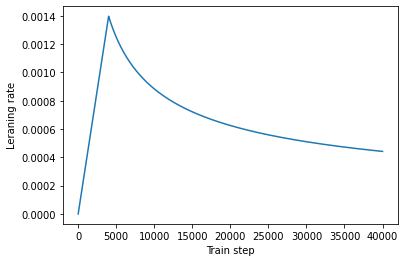

In [83]:
temp_learning_rate_schedule = CustomizedSchedule(d_model)
# 下面是学习率的设计图
plt.plot(
    temp_learning_rate_schedule(
        tf.range(40000, dtype=tf.float32)))
plt.ylabel("Leraning rate")
plt.xlabel("Train step")

In [84]:
loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits = True, reduction = 'none')

# 为了不考虑padding部分的损失，需要mask
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)


In [85]:
# 利用create_padding_mask和create_look_ahead_mask接口构造训练需要的3个mask
def create_masks(inp, tar):
    """
    Encoder:
      - encoder_padding_mask (self attention of EncoderLayer)
      对于encoder中padding值没作用，所以无需attention
    Decoder:
      - look_ahead_mask (self attention of DecoderLayer)
      target位置上的词不能看到之后的词，因为之后的词没预测出来
      - encoder_decoder_padding_mask (encoder-decoder attention of DecoderLayer)
      decoder不应该到encoder的padding上去花费精力
      - decoder_padding_mask (self attention of DecoderLayer)
      decoder也有padding，所以mask掉
    """
    encoder_padding_mask = create_padding_mask(inp)  # 给padding做了mask
    encoder_decoder_padding_mask = create_padding_mask(inp)  # 给encoder_decoder做的padding
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])  # 不能看到后面的词
    decoder_padding_mask = create_padding_mask(tar)  # tar的padding做了mask
    
    decoder_mask = tf.maximum(decoder_padding_mask,
                              look_ahead_mask)  # 广播比较（应该与batch是没关系的？）
    
#     print(encoder_padding_mask.shape)
#     print(encoder_decoder_padding_mask.shape)
#     print(look_ahead_mask.shape)
#     print(decoder_padding_mask.shape)
#     print(decoder_mask.shape)

    
    return encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask

In [86]:
# maximum broadcast 有点意思
import tensorflow as tf
x = tf.constant([-5., 0., 0., 0., 8, 9])
x1 = tf.reshape(x, (2, 1, 1, 3))
y = tf.constant([-3., 9, 8, 7, 8, 0., 0., 8, 9])
y1 = tf.reshape(y, (3, 3))
# print(x1.shape)
# print(y1.shape)
print(x1)
print(y1)
tf.maximum(x1, y1)

tf.Tensor(
[[[[-5.  0.  0.]]]


 [[[ 0.  8.  9.]]]], shape=(2, 1, 1, 3), dtype=float32)
tf.Tensor(
[[-3.  9.  8.]
 [ 7.  8.  0.]
 [ 0.  8.  9.]], shape=(3, 3), dtype=float32)


<tf.Tensor: shape=(2, 1, 3, 3), dtype=float32, numpy=
array([[[[-3.,  9.,  8.],
         [ 7.,  8.,  0.],
         [ 0.,  8.,  9.]]],


       [[[ 0.,  9.,  9.],
         [ 7.,  8.,  9.],
         [ 0.,  8.,  9.]]]], dtype=float32)>

In [87]:
temp_inp, temp_tar = iter(train_dataset.take(1)).next()

In [88]:
print(temp_inp.shape)
print(temp_tar.shape)
create_masks(temp_inp, temp_tar)
# 样本大小是64，不足的补齐35，或者39
# 最后是(64, 1, 39, 39)原因是既不关注前面的padding，也不关注后面的单词

(64, 39)
(64, 40)


(<tf.Tensor: shape=(64, 1, 1, 39), dtype=float32, numpy=
 array([[[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        ...,
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]]], dtype=float32)>,
 <tf.Tensor: shape=(64, 1, 40, 40), dtype=float32, numpy=
 array([[[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1., 1., ..., 1., 1., 1.

# 6 train step

In [89]:
train_loss = keras.metrics.Mean(name = 'train_loss')
train_accuracy = keras.metrics.SparseCategoricalAccuracy(
    name = 'train_accuracy')
# start I have a dream end
@tf.function
def train_step(inp, tar):
    tar_inp  = tar[:, :-1]  # 没带end  decode输入, 比如输入start得到I
    tar_real = tar[:, 1:]  # 没有start  输入的是dream时，输出是end
    
    encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask \
    = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True,
                                     encoder_padding_mask,
                                     decoder_mask,
                                     encoder_decoder_padding_mask)
        loss = loss_function(tar_real, predictions)
    
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(
        zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(tar_real, predictions)
# 一个epochs接近90秒
epochs = 20
for epoch in range(epochs):
    start = time.time()
    # reset后就会从零开始累计
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(),
                train_accuracy.result()))
    
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(
        epoch + 1, train_loss.result(), train_accuracy.result()))
    print('Time take for 1 epoch: {} secs\n'.format(
        time.time() - start))

# loss是正常指标，accuracy只是机器翻译的一个参考指标（没啥意义），可以看趋势
    

Epoch 1 Batch 0 Loss 3.9801 Accuracy 0.0000


Epoch 1 Batch 100 Loss 4.1645 Accuracy 0.0164
Epoch 1 Batch 200 Loss 4.0480 Accuracy 0.0238
Epoch 1 Batch 300 Loss 3.9153 Accuracy 0.0295
Epoch 1 Batch 400 Loss 3.7444 Accuracy 0.0356
Epoch 1 Batch 500 Loss 3.6010 Accuracy 0.0410
Epoch 1 Batch 600 Loss 3.4870 Accuracy 0.0463
Epoch 1 Batch 700 Loss 3.3767 Accuracy 0.0527
Epoch 1 Loss 3.3750 Accuracy 0.0528
Time take for 1 epoch: 374.00975346565247 secs

Epoch 2 Batch 0 Loss 2.6511 Accuracy 0.1016
Epoch 2 Batch 100 Loss 2.5789 Accuracy 0.1031
Epoch 2 Batch 200 Loss 2.5187 Accuracy 0.1082
Epoch 2 Batch 300 Loss 2.4896 Accuracy 0.1130
Epoch 2 Batch 400 Loss 2.4601 Accuracy 0.1166
Epoch 2 Batch 500 Loss 2.4256 Accuracy 0.1197
Epoch 2 Batch 600 Loss 2.3988 Accuracy 0.1225
Epoch 2 Batch 700 Loss 2.3720 Accuracy 0.1248
Epoch 2 Loss 2.3714 Accuracy 0.1248
Time take for 1 epoch: 129.94147634506226 secs

Epoch 3 Batch 0 Loss 2.0604 Accuracy 0.1354
Epoch 3 Batch 100 Loss 2.1629 Accuracy 0.1433
Epoch 3 Batch 200 Loss 2.1614 Accuracy 0.1444
Epoch 3 

# 7 Evaluate and Visualize

In [90]:
"""
eg: A B C D -> E F G H.
Train: A B C D, E F G -> F G H
Eval:  A B C D -> E
       A B C D, E -> F
       A B C D, E F -> G
       A B C D, E F G -> H
类似seq2seq2
不同的是 transformer可以并行的处理，前后没有依赖，而seq2seq前后有依赖
"""
def evaluate(inp_sentence):
    # 文本的句子转换为id的句子
    input_id_sentence = [pt_tokenizer.vocab_size] \
    + pt_tokenizer.encode(inp_sentence) + [pt_tokenizer.vocab_size + 1]
    # transformer转换是两维的，因此转换
    # encoder_input.shape: (1, input_sentence_length)
    encoder_input = tf.expand_dims(input_id_sentence, 0)
    
    # decoder_input.shape: (1, 1)
    # 我们预测一个词就放入decoder_input，decoder_input给多个就可以预测多个，我们给一个
    decoder_input = tf.expand_dims([en_tokenizer.vocab_size], 0)
    
    for i in range(max_length):
        # 产生mask并传给transformer
        encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask \
        = create_masks(encoder_input, decoder_input)
        # predictions.shape: (batch_size, output_target_len, target_vocab_size)
        predictions, attention_weights = transformer(
            encoder_input,
            decoder_input,
            False,
            encoder_padding_mask,
            decoder_mask,
            encoder_decoder_padding_mask)
        # predictions.shape: (batch_size, output_target_len, target_vocab_size)
        # decoder每次输出的维度和输入的维度是一致的，所以是最后一个
        predictions = predictions[:, -1, :]
        # 预测值就是概率最大的那个的索引
        predicted_id = tf.cast(tf.argmax(predictions, axis = -1),
                               tf.int32)
        # 如果等于end_id，预测结束
        if tf.equal(predicted_id, en_tokenizer.vocab_size + 1):
            return tf.squeeze(decoder_input, axis = 0), attention_weights
        # 如果predicted_id不是end_id，添加到新的decoder_input中
        decoder_input = tf.concat([decoder_input, [predicted_id]],
                                  axis = -1)
    return tf.squeeze(decoder_input, axis = 0), attention_weights
        
        

In [91]:
def plot_encoder_decoder_attention(attention, input_sentence,
                                   result, layer_name):
    fig = plt.figure(figsize = (16, 8))
    
    input_id_sentence = pt_tokenizer.encode(input_sentence)
    
    # attention.shape: (num_heads, tar_len, input_len)
    attention = tf.squeeze(attention[layer_name], axis = 0)
    
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)
        
        ax.matshow(attention[head][:-1, :])
        
        fontdict = {'fontsize': 10}
        
        ax.set_xticks(range(len(input_id_sentence) + 2))
        ax.set_yticks(range(len(result)))
        
        ax.set_ylim(len(result) - 1.5, -0.5)
        
        ax.set_xticklabels(
            ['<start>'] + [pt_tokenizer.decode([i]) for i in input_id_sentence] + ['<end>'],
            fontdict = fontdict, rotation = 90)
        ax.set_yticklabels(
            [en_tokenizer.decode([i]) for i in result if i < en_tokenizer.vocab_size],
            fontdict = fontdict)
        ax.set_xlabel('Head {}'.format(head + 1))
    plt.tight_layout()
    plt.show()      

# translate

In [92]:
def translate(input_sentence, layer_name = ''):
    result, attention_weights = evaluate(input_sentence)
    
    predicted_sentence = en_tokenizer.decode(
        [i for i in result if i < en_tokenizer.vocab_size])
    
    print("Input: {}".format(input_sentence))
    print("Predicted translation: {}".format(predicted_sentence))
    
    if layer_name:
        plot_encoder_decoder_attention(attention_weights, input_sentence,
                                       result, layer_name)

In [93]:
translate('está muito frio aqui.')

Input: está muito frio aqui.
Predicted translation: it 's very cold here , ok , ok , here 's a lot of cold here .


In [94]:
translate('isto é minha vida')

Input: isto é minha vida
Predicted translation: this is my life .


In [95]:
translate('você ainda está em casa?')

Input: você ainda está em casa?
Predicted translation: are you home , then ?


In [96]:
translate('este é o primeiro livro que eu já li')

Input: este é o primeiro livro que eu já li
Predicted translation: this is the first book i already have .


Input: este é o primeiro livro que eu já li
Predicted translation: this is the first book i already have .


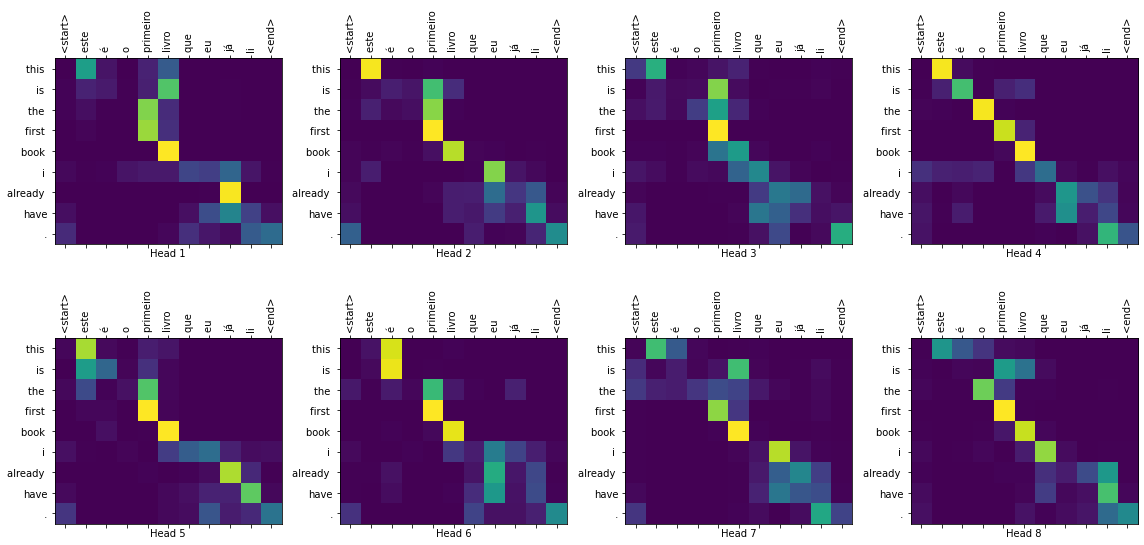

In [97]:
translate('este é o primeiro livro que eu já li',
          layer_name = 'decoder_layer4_att2')